<a href="https://colab.research.google.com/github/alexandre-pinon/voltron/blob/feature%2Fai/bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Climate time series data analysis

## Config

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

In [52]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [53]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

## Data loading

In [54]:
# Parse dates and set date column to index
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv",
                       parse_dates=["date"],
                       index_col=["date"])
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv",
                      parse_dates=["date"],
                      index_col=["date"])

## Data vizualisation

In [55]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [57]:
train_df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1462, freq=None)

In [58]:
def plot_time_series(ax,
                     timesteps,
                     values,
                     title=None,
                     format='.',
                     start=0,
                     end=None,
                     label=None,
                     c='b'):
    """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  ax : matplotlib.Axes to plot
  timesteps : array of timesteps
  values : array of values across time
  title : title of plot
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  c : color, default 'blue'
  """
    ax.plot(timesteps[start:end], values[start:end], format, c=c, label=label)
    ax.set_xlabel("Time")
    ax.tick_params('x', labelrotation=45)
    ax.grid(True)

    if title:
      ax.set_title(title, fontsize=16)
    if label:
      ax.legend(fontsize=14, bbox_to_anchor=(1, 1), loc='upper left')


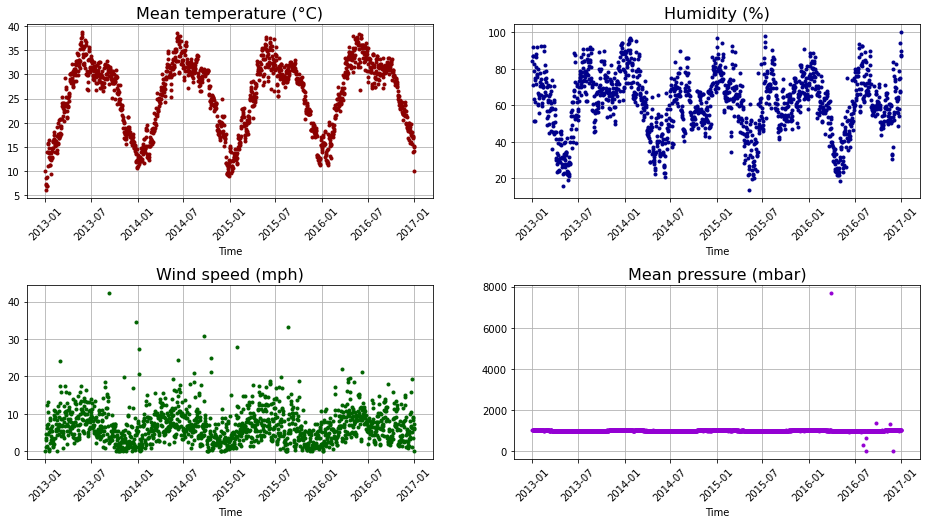

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(16, 8),
                                             gridspec_kw={'hspace': .5})

plot_time_series(ax1, train_df.index, train_df["meantemp"], "Mean temperature (°C)", c='darkred')
plot_time_series(ax2, train_df.index, train_df["humidity"], "Humidity (%)", c='darkblue')
plot_time_series(ax3, train_df.index, train_df["wind_speed"], "Wind speed (mph)", c='darkgreen')
plot_time_series(ax4, train_df.index, train_df["meanpressure"], "Mean pressure (mbar)", c='darkviolet')

# fig.savefig('./graphs/train_data.png', facecolor='white')

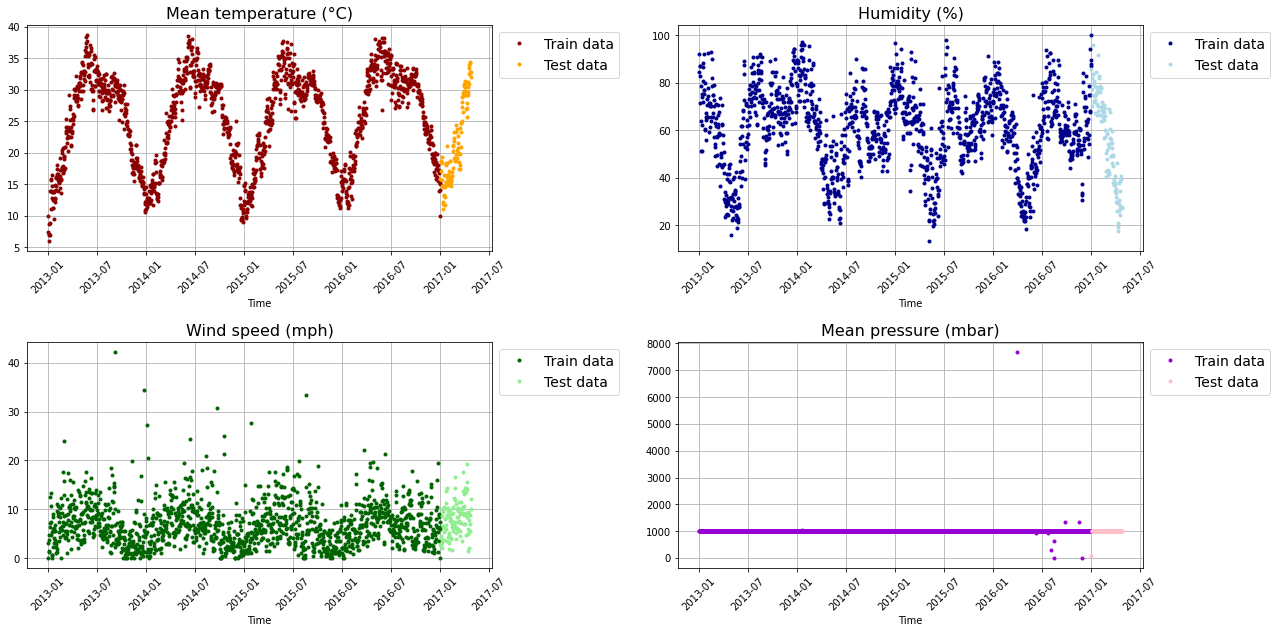

In [60]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(20, 10),
                                             gridspec_kw={
                                                 'wspace': .4,
                                                 'hspace': .4
                                             })

plot_time_series(ax1,
                 train_df.index,
                 train_df["meantemp"],
                 "Mean temperature (°C)",
                 label='Train data',
                 c='darkred')
plot_time_series(ax1,
                 test_df.index,
                 test_df["meantemp"],
                 "Mean temperature (°C)",
                 label='Test data',
                 c='orange')
plot_time_series(ax2,
                 train_df.index,
                 train_df["humidity"],
                 "Humidity (%)",
                 label='Train data',
                 c='darkblue')
plot_time_series(ax2,
                 test_df.index,
                 test_df["humidity"],
                 "Humidity (%)",
                 label='Test data',
                 c='lightblue')
plot_time_series(ax3,
                 train_df.index,
                 train_df["wind_speed"],
                 "Wind speed (mph)",
                 label='Train data',
                 c='darkgreen')
plot_time_series(ax3,
                 test_df.index,
                 test_df["wind_speed"],
                 "Wind speed (mph)",
                 label='Test data',
                 c='lightgreen')
plot_time_series(ax4,
                 train_df.index,
                 train_df["meanpressure"],
                 "Mean pressure (mbar)",
                 label='Train data',
                 c='darkviolet')
plot_time_series(ax4,
                 test_df.index,
                 test_df["meanpressure"],
                 "Mean pressure (mbar)",
                 label='Test data',
                 c='pink')

# fig.savefig('./graphs/train_plus_test_data.png', facecolor='white')

# Univariate predictions on mean temperature

## Model 0 : Naïve forecast (baseline)

Let's start with a baseline: the [Naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)

For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is,
\begin{equation*}
  y_t = y_{t-1} 
\end{equation*}

In [61]:
X_train = train_df.index
X_test = test_df.index
y_train = train_df["meantemp"]
y_test = test_df["meantemp"]

In [62]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1462,)
X_test shape: (114,)
y_train shape: (1462,)
y_test shape: (114,)


In [63]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(date
 2017-01-01    15.913043
 2017-01-02    18.500000
 2017-01-03    17.111111
 2017-01-04    18.700000
 2017-01-05    18.388889
 2017-01-06    19.318182
 2017-01-07    14.708333
 2017-01-08    15.684211
 2017-01-09    14.571429
 2017-01-10    12.111111
 Name: meantemp, dtype: float64, date
 2017-04-14    30.500000
 2017-04-15    31.222222
 2017-04-16    31.000000
 2017-04-17    32.555556
 2017-04-18    34.000000
 2017-04-19    33.500000
 2017-04-20    34.500000
 2017-04-21    34.250000
 2017-04-22    32.900000
 2017-04-23    32.875000
 Name: meantemp, dtype: float64)

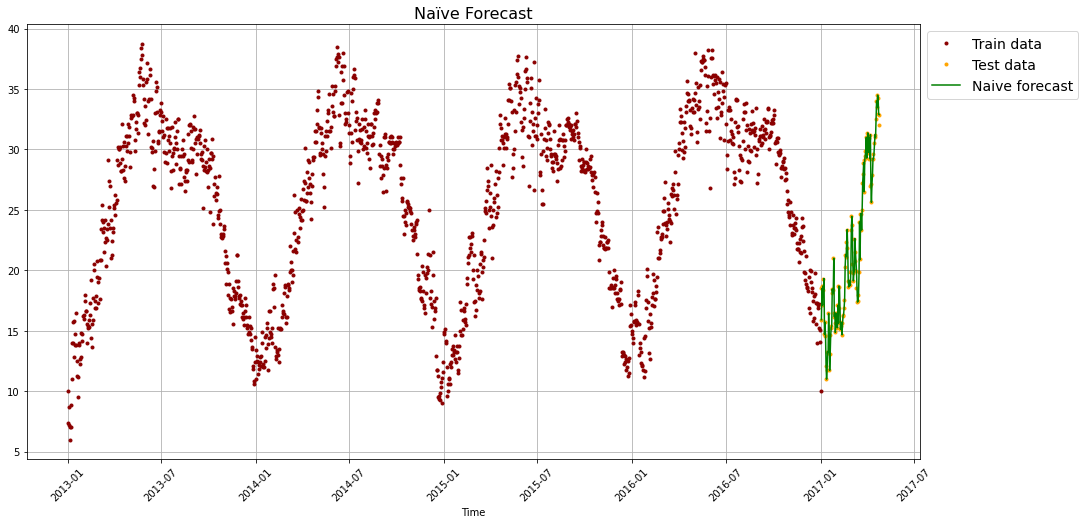

In [64]:
# Plot naive forecast
fig, ax = plt.subplots(figsize=(16, 8))
plot_time_series(ax, X_train, y_train, label="Train data", c='darkred')
plot_time_series(ax, X_test, y_test, label="Test data", c='orange')
plot_time_series(ax, X_test[1:], naive_forecast, title="Naïve Forecast", format="-", label="Naive forecast", c='green');

Let's zoom in to get a better look

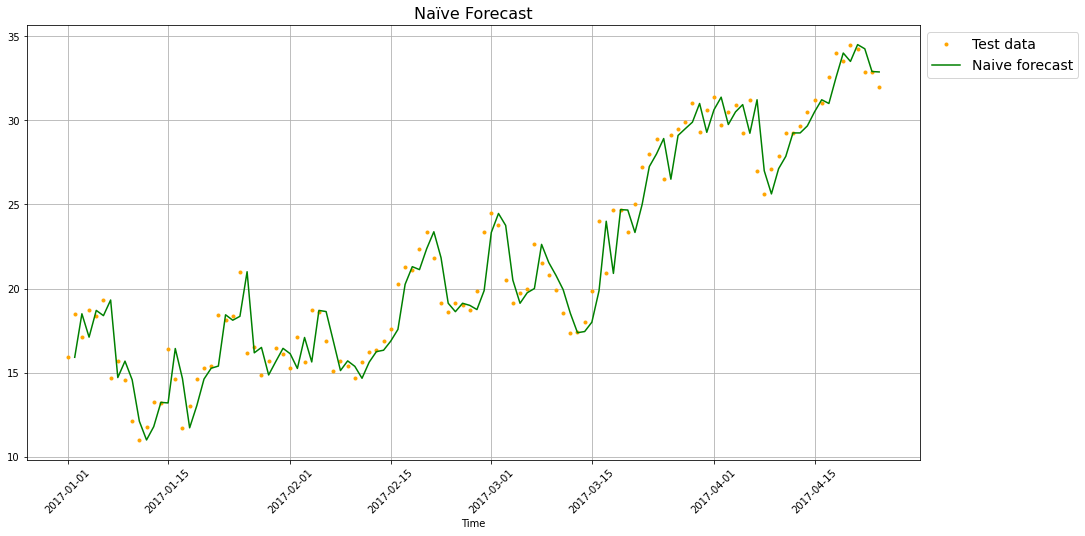

In [65]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_time_series(ax, X_test, y_test, label="Test data", c='orange')
plot_time_series(ax, X_test[1:], naive_forecast, title="Naïve Forecast", format="-", label="Naive forecast", c='green');

## Evaluate model

In [66]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [67]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [68]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
pd.Series(naive_results)

mae     1.317634
mse     2.855880
rmse    1.689935
mape    6.656282
mase    1.008676
dtype: float32

In [69]:
# Find average mean temperature in test dataset
tf.reduce_mean(y_test).numpy()

21.713078920228238

## Windowing dataset

Windowing is a method to turn a time series dataset into supervised learning problem.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:

Window for one week (univariate time series)

- [0, 1, 2, 3, 4, 5, 6] -> [7]
- [1, 2, 3, 4, 5, 6, 7] -> [8]
- [2, 3, 4, 5, 6, 7, 8] -> [9]

In [70]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [71]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

## Creating training/validation/test datasets

In [75]:
def make_train_val_splits(windows, labels, val_split=0.2):
  """
  Splits matching pairs of windows and labels into train and val splits.
  """
  split_size = int(len(windows) * (1-val_split)) # this will default to 80% train/20% val
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  val_windows = windows[split_size:]
  val_labels = labels[split_size:]
  return train_windows, val_windows, train_labels, val_labels

In [77]:
train_windows, train_labels = make_windows(y_train.to_numpy())
train_windows, val_windows, train_labels, val_labels = make_train_val_splits(train_windows, train_labels, val_split=0.2)
test_windows, test_labels = make_windows(y_test.to_numpy())

In [78]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {train_windows[i]} -> Label: {train_labels[i]}")

# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {train_windows[i-3]} -> Label: {train_labels[i-3]}")

Window: [10.          7.4         7.16666667  8.66666667  6.          7.
  7.        ] -> Label: [8.85714286]
Window: [7.4        7.16666667 8.66666667 6.         7.         7.
 8.85714286] -> Label: [14.]
Window: [ 7.16666667  8.66666667  6.          7.          7.          8.85714286
 14.        ] -> Label: [11.]
Window: [23.71428571 23.42857143 24.         25.5625     25.06666667 24.5625
 24.25      ] -> Label: [22.375]
Window: [23.42857143 24.         25.5625     25.06666667 24.5625     24.25
 22.375     ] -> Label: [24.06666667]
Window: [24.         25.5625     25.06666667 24.5625     24.25       22.375
 24.06666667] -> Label: [23.9375]


In [83]:
print(f"train_windows shape: {train_windows.shape}")
print(f"val_windows shape: {val_windows.shape}")
print(f"test_windows shape: {test_windows.shape}")
print("-"*30)
print(f"train_labels shape: {train_labels.shape}")
print(f"val_labels shape: {val_labels.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_windows shape: (1164, 7)
val_windows shape: (291, 7)
test_windows shape: (107, 7)
------------------------------
train_labels shape: (1164, 1)
val_labels shape: (291, 1)
test_labels shape: (107, 1)


## Model checkpoint

In [76]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file


## Model 1: Dense model (window = 7, horizon = 1)
